In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from scipy import optimize

font = {'family' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
data = pd.read_csv('termodvoika.csv')
print(data.head())

   T, C  E, mV  t, s      t, m
0  92.0   64.8     0  0.000000
1  90.0   62.9   118  1.966667
2  88.0   61.1   217  3.616667
3  86.0   59.1   326  5.433333
4  84.0   57.3   437  7.283333


## Калибрация на термодвойката

-0.001296166607421727 1.1468937834405615 -29.88816201597404
0.2778464603128773
0.24225997587969042
inverse mean
0.2995576651777862


Text(0, 0.5, 'E, mV')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


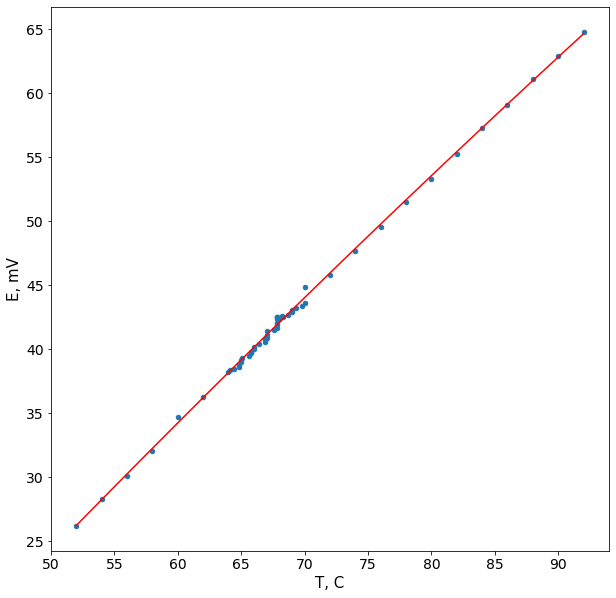

In [4]:
f = lambda x, a, b, c: a*x**2 + b*x + c

fig, ax = plt.subplots(figsize=(10, 10))
data.plot.scatter(x='T, C', y='E, mV', ax=ax)

popt, pcov = optimize.curve_fit(f, data['T, C'], data['E, mV'])
a, b, c = popt
print(a, b, c)
e_rmse = (pd.Series([
    (f(x, a, b, c) - y)**2 for (x, y) in zip(data['T, C'], data['E, mV'])
    ]).mean())**0.5
print(e_rmse)
print(e_rmse/b)

f_1 = lambda e: (-b+(b**2 - 4*a*(c-e))**0.5)/(2*a)

inverse = pd.Series([
    (f_1(e) - t)**2 for (e, t) in zip(data['E, mV'], data['T, C'])
])
print('inverse mean')
T_rmse = (inverse.mean())**0.5
print((T_rmse**2 + (0.1/b)**2)**0.5)
xs = np.linspace(data['T, C'].min(), data['T, C'].max(), 50)
ys = [f(x, a, b, c) for x in xs]
plt.plot(xs, ys, 'r')

ax.set_xlabel('T, C', fontsize=15)
ax.set_ylabel('E, mV', fontsize=15)


## Експоненциално охлаждане

l=0.00032836091256944116 s^-1, t1=1534.200422062885 s, t2=1651.854009655589 s, T_ph=67.85714286065152 C, T_r=30.995065974273977 C


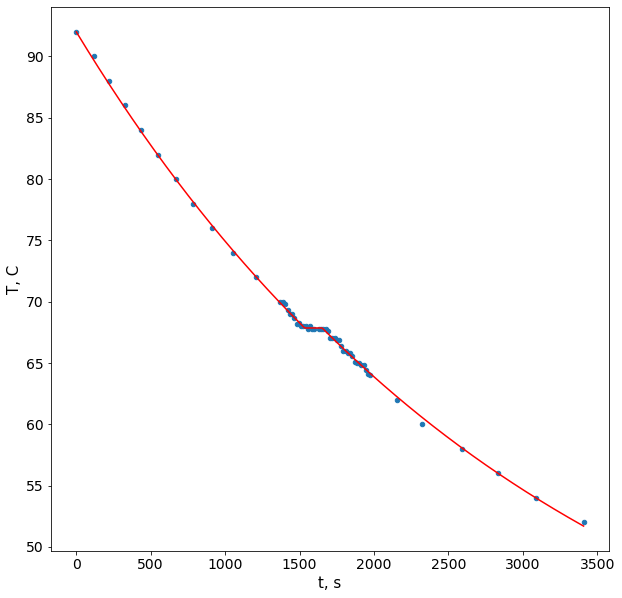

In [17]:
T_0 = 92
def T(ts, l, t1, t2, T_r):
    T_ph = T_r + (T_0 - T_r)*np.exp(-l*t1)
    res = []
    for t in ts:
        if 0 <= t < t1:
            res.append(T_r + (T_0 - T_r)*np.exp(-l*t))
        elif t1 <= t < t2:
            res.append(T_ph)
        elif t2 <= t:
            res.append(T_r + (T_ph - T_r)*np.exp(-l*(t-t2)))
    return np.array(res)

params, _ = optimize.curve_fit(T, np.array(data['t, s']), np.array(data['T, C']), p0=[1/5000, 1500, 1800, 20])
l, t1, t2, T_r = params
T_ph = T_r + (T_0 - T_r)*np.exp(-l*t1)


print(f'l={l} s^-1, t1={t1} s, t2={t2} s, T_ph={T_ph} C, T_r={T_r} C')

xs = np.linspace(data['t, s'].min(), data['t, s'].max(), 500)
ys = T(xs, l, t1, t2, T_r)


fig, ax = plt.subplots(figsize=(10, 10))
data.plot.scatter(x='t, s', y='T, C', ax=ax)
plt.plot(xs, ys, 'r')

ax.set_xlabel('t, s', fontsize=15)
ax.set_ylabel('T, C', fontsize=15)

plt.show()